### 1 Linear Regression

Linear regression is an approach we use to model the relationship between a scalar dependent variable $y$ and one or more explanatory variables (aka independent variables) denoted by $X$. In machine learning parlance, these explanatory variables or predictors are called features and target or the dependent variable labels. Regression modesl are models which predict a continuous outcome.

##### Univariate Regression

The simplest possible relationship between two variables is a univariate regression when there is only one feature to be explained.
$$
y \approx w_0+w_1 x_1
$$

##### Multivariate Regression
If there multiple features that are to be mapped to a target variable, then it is a multivariate regression problem.
$$
y \approx w_0+w_1 x_1+w_2 x_2+w_3 x_3+\cdots+w_n x_n
$$
or more generally
$$
y_i \approx \sum_j w_j X_{i j}
$$
where $i$ labels different observations and $j$ labels different features.
If we can measure some $\left(x_i, y_i\right)$ pairs, we could calculate our model parameters $w$. Then we could predict $y$ in the future based on $x$, or even try to influence $y$ in the future by controlling $x$. This is achieved by minimizing the mean squared error,
$$
L=\frac{1}{n} \sum_{i=1}^n\left(y_i-w_0-\sum_{j=1}^p x_{i j} w_j\right)^2
$$


### 2 The workflow
We’ll employ the following linear regressor from scikit-learn for stock / equity index price prediction.
* Linear Regression
* Lasso Regression
* Ridge Regression
* Elastic Net Regression

| Steps | Workflow | Remarks |
| :--- | :--- | :--- |
| Step 1 | Ideation | Predict next trading day index price from the given dataset |
| Step 2 |Data Collection | Load the dataset from my github page |
| Step 3 | Exploratory Data Analysis | Study summary statistics |
| Step 4 | Cleaning Dataset | Data already cleaned, no further imputation required |
| Step 5 | Transformation | Perform feature scaling based on EDA |
| Step 6 | Modeling | Building and training linear regressor |
| Step 7 | Metrics | Validating the model performance using score method |

In [1]:
## Import Libraries

# Data Manipulation
import numpy as np
import pandas as pd
# Visualizaiton
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(rc={'figure.figsize': (20, 8)})
# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler,
MinMaxScaler)
from sklearn.pipeline import Pipeline
# Regressor
from sklearn.linear_model import (LinearRegression,
                                    Lasso,
                                    Ridge,
                                    ElasticNet)
# Metrics
from sklearn.metrics import mean_squared_error
# set display options
pd.options.display.float_format = "{:,.4f}".format
pd.set_option('display.max_columns', 100)
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\svbes\AppData\Local\Temp\ipykernel_11452\2774358743.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


#### 2.1 Load data

In [4]:
# load nifty index data
df = pd.read_csv('https://raw.githubusercontent.com/kannansingaravelu/datasets/main/niftyindex.csv',
index_col=0,
dayfirst=True)

df.head()

,Open,High,Low,Close,Volume
02/01/2012,"4,640.2000","4,645.9500","4,588.0500","4,636.7500",108461000
03/01/2012,"4,675.8000","4,773.1000","4,675.8000","4,765.3000",146621008
04/01/2012,"4,774.9500","4,782.8500","4,728.8500","4,749.6500",165939008
05/01/2012,"4,749.0000","4,779.8000","4,730.1500","4,749.9500",177863008
06/01/2012,"4,724.1500","4,794.9000","4,686.8500","4,754.1000",176057008


#### 2.2 EDA of Original dataset

In [4]:
# descriptive statistics
df.describe()


,Open,High,Low,Close,Volume
count,"2,719.0000","2,719.0000","2,719.0000","2,719.0000","2,719.0000"
mean,"10,124.8980","10,175.2921","10,057.4698","10,117.5710","289,222,065.6433"
std,"3,709.6071","3,725.5270","3,685.3052","3,706.9455","195,276,778.8519"
min,"4,640.2000","4,645.9500","4,588.0500","4,636.7500","2,826,000.0000"
25%,"7,637.0000","7,681.0000","7,581.6500","7,623.8000","159,178,008.0000"
50%,"9,376.9500","9,431.9000","9,301.3500","9,351.8500","219,496,064.0000"
75%,"11,700.8500","11,755.1250","11,631.3250","11,684.0000","340,908,832.0000"
max,"18,871.9500","18,887.6000","18,778.2000","18,812.5000","1,810,971,008.0000"


#### 2.3 Cleaning & Imputation
Data is already cleaned. No further processing or imputation required

In [5]:
# check for missing values
df.isnull().sum()


Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

#### 2.4 Feature Engineering
Features are also known as an independent variable which are used to determine the value of the
target variable. We will create features and target (label) from the raw dataset.


In [6]:
# create features
def create_features(frame):
    df = frame.copy()
    multiplier = 2
    # features
    df['OC'] = df['Close'] / df['Open'] - 1
    df['HC'] = df['High'] / df['Low'] - 1
    df['GAP'] = df['Open'] / df['Close'].shift(1) - 1
    df['RET'] = np.log(df['Close'] / df['Close'].shift(1))
    for i in [7, 14, 28]:
        df['PCHG' + str(i)] = df['Close'].pct_change(i)
        df['VCHG' + str(i)] = df['Volume'].pct_change(i)
        df['RET' + str(i)] = df['RET'].rolling(i).sum()
        df['MA' + str(i)] = df['Close'] / df['Close'].rolling(i).mean()
        df['VMA' + str(i)] = df['Volume'] / df['Volume'].rolling(i).mean()
        df['OC'+ str(i)] = df['OC'].rolling(i).mean()
        df['HC'+ str(i)] = df['HC'].rolling(i).mean()
        df['GAP'+ str(i)] = df['GAP'].rolling(i).mean()
        df['STD'+ str(i)] = df['RET'].rolling(i).std()
        df['UB'+str(i)] = df['Close'].rolling(i).mean() + df['Close'].rolling(i).std() * multiplier
        df['LB'+str(i)] = df['Close'].rolling(i).mean() - df['Close'].rolling(i).std() * multiplier
    # drop NaN values
    df['Label'] = df['Close'].shift(-1)
    df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
    df.dropna(inplace=True)
    return df


#### 2.4.1 Feature Specification
Features or Predictors are also known as an independent variable which are used to determine the
value of the target variable. We will derive a features set from the original dataset.

In [7]:
# features
df1 = create_features(df)
display(df1.shape)
# verify the output
df1.head(5)


(2690, 38)

,OC,HC,GAP,RET,PCHG7,VCHG7,RET7,MA7,VMA7,OC7,HC7,GAP7,STD7,UB7,LB7,PCHG14,VCHG14,RET14,MA14,VMA14,OC14,HC14,GAP14,STD14,UB14,LB14,PCHG28,VCHG28,RET28,MA28,VMA28,OC28,HC28,GAP28,STD28,UB28,LB28,Label
10/02/2012,-0.0034,0.0162,-0.0023,-0.0057,0.0279,-0.0406,0.0275,1.0058,0.9455,0.0008,0.0145,0.0032,0.0065,"5,442.1990","5,259.1296",0.0660,0.0195,0.0639,1.0249,1.0192,0.0020,0.0142,0.0026,0.0107,"5,486.1450","5,015.7836",0.1606,1.0777,0.1490,1.0646,1.0967,0.0029,0.0138,0.0024,0.0104,"5,509.5275","4,600.9761","5,390.2000"
13/02/2012,0.0015,0.0130,0.0001,0.0016,0.0228,-0.4628,0.0226,1.0042,0.8406,0.0011,0.0146,0.0022,0.0064,"5,428.6264","5,307.0736",0.0682,0.1478,0.0659,1.0217,0.8150,0.0018,0.0146,0.0030,0.0106,"5,489.4954","5,061.5689",0.1311,0.2383,0.1232,1.0616,0.8783,0.0023,0.0135,0.0022,0.0094,"5,534.1504","4,620.9889","5,416.0500"
14/02/2012,0.0066,0.0093,-0.0017,0.0048,0.0169,-0.0734,0.0168,1.0066,0.9424,0.0006,0.0138,0.0018,0.0057,"5,438.1094","5,323.3621",0.0563,-0.0030,0.0548,1.0226,0.9043,0.0014,0.0140,0.0026,0.0101,"5,504.1623","5,088.1448",0.1403,0.2138,0.1313,1.0617,0.9683,0.0027,0.0134,0.0020,0.0093,"5,556.5167","4,646.2225","5,531.9500"
15/02/2012,0.0131,0.0149,0.0082,0.0212,0.0318,0.4616,0.0313,1.0235,1.3794,0.0030,0.0143,0.0015,0.0091,"5,529.6862","5,280.4423",0.0724,0.4343,0.0699,1.0393,1.3696,0.0022,0.0145,0.0028,0.0111,"5,549.6900","5,095.9958",0.1646,0.7675,0.1524,1.0785,1.4768,0.0032,0.0136,0.0023,0.0098,"5,590.9195","4,667.6769","5,521.9500"
16/02/2012,0.0015,0.0087,-0.0033,-0.0018,0.0350,0.4904,0.0344,1.0166,1.1224,0.0053,0.0131,-0.0003,0.0086,"5,566.1259","5,297.3741",0.0610,0.2507,0.0592,1.0330,1.1571,0.0025,0.0143,0.0018,0.0112,"5,584.5662","5,106.4410",0.1615,0.5339,0.1497,1.0708,1.2490,0.0030,0.0131,0.0024,0.0098,"5,617.1127","4,696.3302","5,564.3000"


#### 2.4.2 Target or Label Definition
Label or the target variable is also known as the dependent variable. Here, the target variable is
the closing price of the index the next trading day.


In [8]:
# label
y = np.array(df1['Label'])
y


array([ 5390.2 ,  5416.05,  5531.95, ..., 18122.5 , 18191.  , 18105.3 ])

#### 2.4.3 Feature Selection
Reduce the number of input variables that are believed to be most useful to a model. We use
correlation measures which is one the filter methods to address multicollinearity among features.


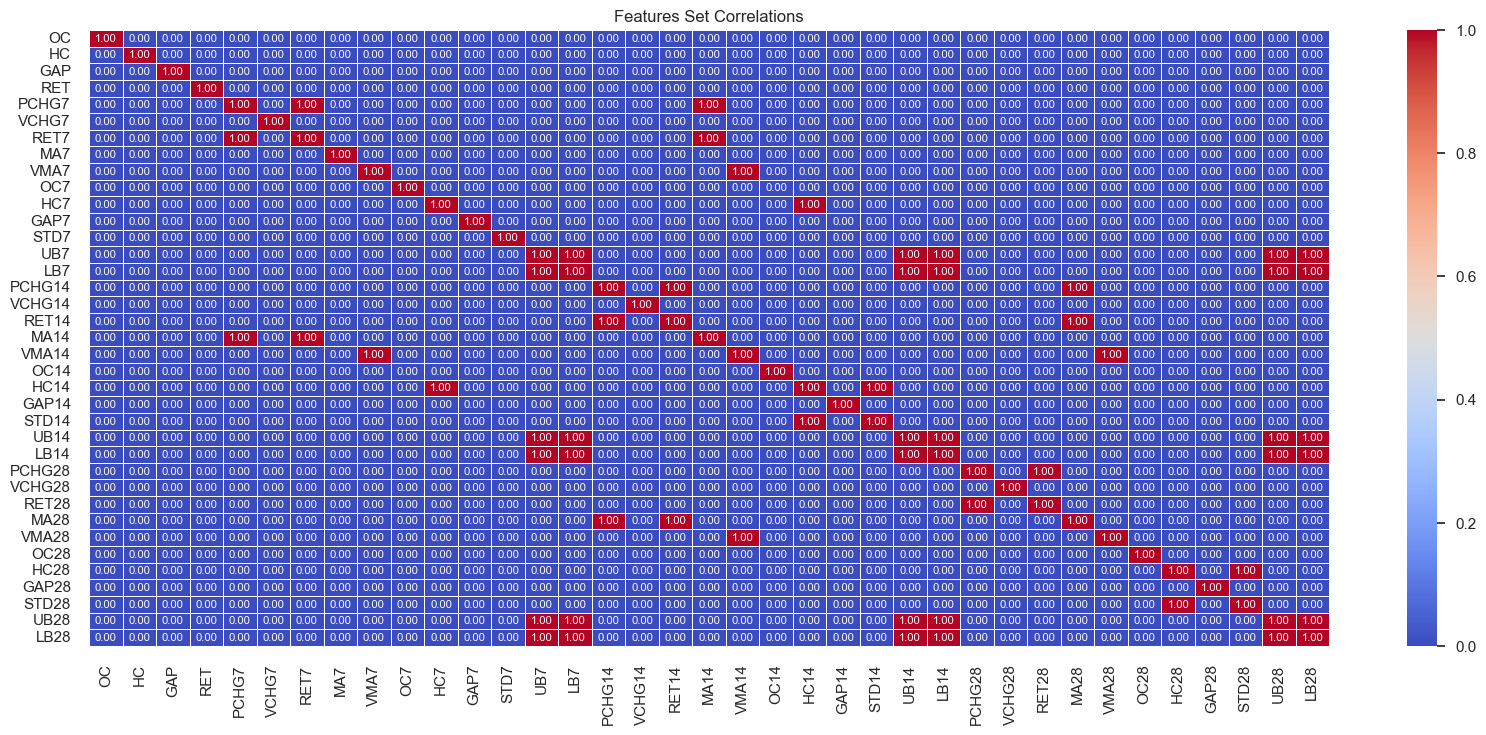

In [9]:
# drop label from dataframe
df1.drop('Label', axis=1, inplace=True)
# remove features that are highly correlated
sns.heatmap(df1.corr()>0.9,
            annot=True,
            annot_kws={"size": 8},
            fmt=".2f",
            linewidth=.5,
            cmap="coolwarm",
            xticklabels=True, 
            yticklabels=True,
            cbar=True); #cmap="crest", virids, magma
plt.title('Features Set Correlations');

In [9]:
# remove the first feature that is correlated with any other feature
def correlated_features(data, threshold=0.9):
    col_corr = set()
    corr_matrix = df1.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr


In [10]:
# total correlated features
drop_correlated_features = correlated_features(df1)
# drop the highly correlated features
X = df1.drop(drop_correlated_features, axis=1)
# record feature names
feature_names = X.columns

In [11]:
# display the new features set
X

,OC,HC,GAP,RET,PCHG7,VCHG7,MA7,VMA7,OC7,HC7,GAP7,STD7,UB7,PCHG14,VCHG14,OC14,GAP14,PCHG28,VCHG28,OC28,HC28,GAP28
10/02/2012,-0.0034,0.0162,-0.0023,-0.0057,0.0279,-0.0406,1.0058,0.9455,0.0008,0.0145,0.0032,0.0065,"5,442.1990",0.0660,0.0195,0.0020,0.0026,0.1606,1.0777,0.0029,0.0138,0.0024
13/02/2012,0.0015,0.0130,0.0001,0.0016,0.0228,-0.4628,1.0042,0.8406,0.0011,0.0146,0.0022,0.0064,"5,428.6264",0.0682,0.1478,0.0018,0.0030,0.1311,0.2383,0.0023,0.0135,0.0022
14/02/2012,0.0066,0.0093,-0.0017,0.0048,0.0169,-0.0734,1.0066,0.9424,0.0006,0.0138,0.0018,0.0057,"5,438.1094",0.0563,-0.0030,0.0014,0.0026,0.1403,0.2138,0.0027,0.0134,0.0020
15/02/2012,0.0131,0.0149,0.0082,0.0212,0.0318,0.4616,1.0235,1.3794,0.0030,0.0143,0.0015,0.0091,"5,529.6862",0.0724,0.4343,0.0022,0.0028,0.1646,0.7675,0.0032,0.0136,0.0023
16/02/2012,0.0015,0.0087,-0.0033,-0.0018,0.0350,0.4904,1.0166,1.1224,0.0053,0.0131,-0.0003,0.0086,"5,566.1259",0.0610,0.2507,0.0025,0.0018,0.1615,0.5339,0.0030,0.0131,0.0024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23/12/2022,-0.0095,0.0152,-0.0083,-0.0178,-0.0457,0.0645,0.9767,1.1157,-0.0050,0.0132,-0.0017,0.0085,"18,669.0039",-0.0478,-0.2321,-0.0025,-0.0010,-0.0324,-0.1175,-0.0009,0.0090,-0.0003
26/12/2022,0.0103,0.0174,0.0013,0.0116,-0.0217,-0.0354,0.9912,0.8942,-0.0020,0.0136,-0.0011,0.0103,"18,604.7406",-0.0337,-0.1888,-0.0019,-0.0005,-0.0215,-0.1944,-0.0005,0.0094,-0.0002
27/12/2022,0.0023,0.0101,0.0042,0.0065,-0.0075,-0.2283,0.9987,1.1366,-0.0013,0.0136,0.0002,0.0106,"18,577.5673",-0.0231,0.0686,-0.0014,-0.0002,-0.0115,0.0685,-0.0004,0.0096,0.0000
28/12/2022,0.0021,0.0058,-0.0026,-0.0005,-0.0162,0.2520,1.0005,0.9989,-0.0020,0.0129,-0.0003,0.0098,"18,464.3870",-0.0262,-0.0441,-0.0014,-0.0004,-0.0101,-0.0248,-0.0002,0.0094,-0.0001


#### 2.4.4 EDA for Feature Scaling
The choice of scaling techniques to be used should come from the Exploratory Data Analysis of
features set.


In [12]:
# decide which scaling to use
X.describe()


,OC,HC,GAP,RET,PCHG7,VCHG7,MA7,VMA7,OC7,HC7,GAP7,STD7,UB7,PCHG14,VCHG14,OC14,GAP14,PCHG28,VCHG28,OC28,HC28,GAP28
count,"2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000","2,690.0000"
mean,-0.0007,0.0119,0.0012,0.0005,0.0036,0.1016,1.0014,1.0024,-0.0007,0.0119,0.0012,0.0090,"10,363.3054",0.0074,0.1658,-0.0007,0.0012,0.0153,0.1229,-0.0007,0.0119,0.0012
std,0.0089,0.0082,0.0063,0.0108,0.0283,1.9471,0.0147,0.2179,0.0030,0.0061,0.0026,0.0058,"3,755.5770",0.0405,4.8659,0.0021,0.0020,0.0566,2.2287,0.0015,0.0050,0.0014
min,-0.0682,0.0025,-0.0914,-0.1390,-0.2294,-0.9925,0.8703,0.0094,-0.0159,0.0050,-0.0287,0.0014,"4,937.6487",-0.3164,-0.9904,-0.0108,-0.0205,-0.3675,-0.9919,-0.0072,0.0059,-0.0100
25%,-0.0051,0.0073,-0.0010,-0.0046,-0.0119,-0.1811,0.9930,0.8633,-0.0025,0.0087,0.0002,0.0058,"7,849.8332",-0.0138,-0.1996,-0.0018,0.0004,-0.0164,-0.2094,-0.0015,0.0091,0.0005
50%,-0.0005,0.0100,0.0015,0.0007,0.0053,0.0021,1.0029,0.9701,-0.0006,0.0107,0.0013,0.0080,"9,681.1755",0.0092,-0.0056,-0.0006,0.0013,0.0187,-0.0117,-0.0006,0.0110,0.0013
75%,0.0039,0.0139,0.0039,0.0062,0.0198,0.2130,1.0103,1.1034,0.0012,0.0136,0.0024,0.0106,"11,955.6179",0.0312,0.2298,0.0006,0.0022,0.0513,0.2552,0.0003,0.0134,0.0020
max,0.0931,0.1875,0.0448,0.0840,0.1463,98.2647,1.0654,2.4288,0.0140,0.0904,0.0156,0.0735,"18,937.7871",0.1879,251.1766,0.0061,0.0131,0.2088,112.8719,0.0035,0.0536,0.0074


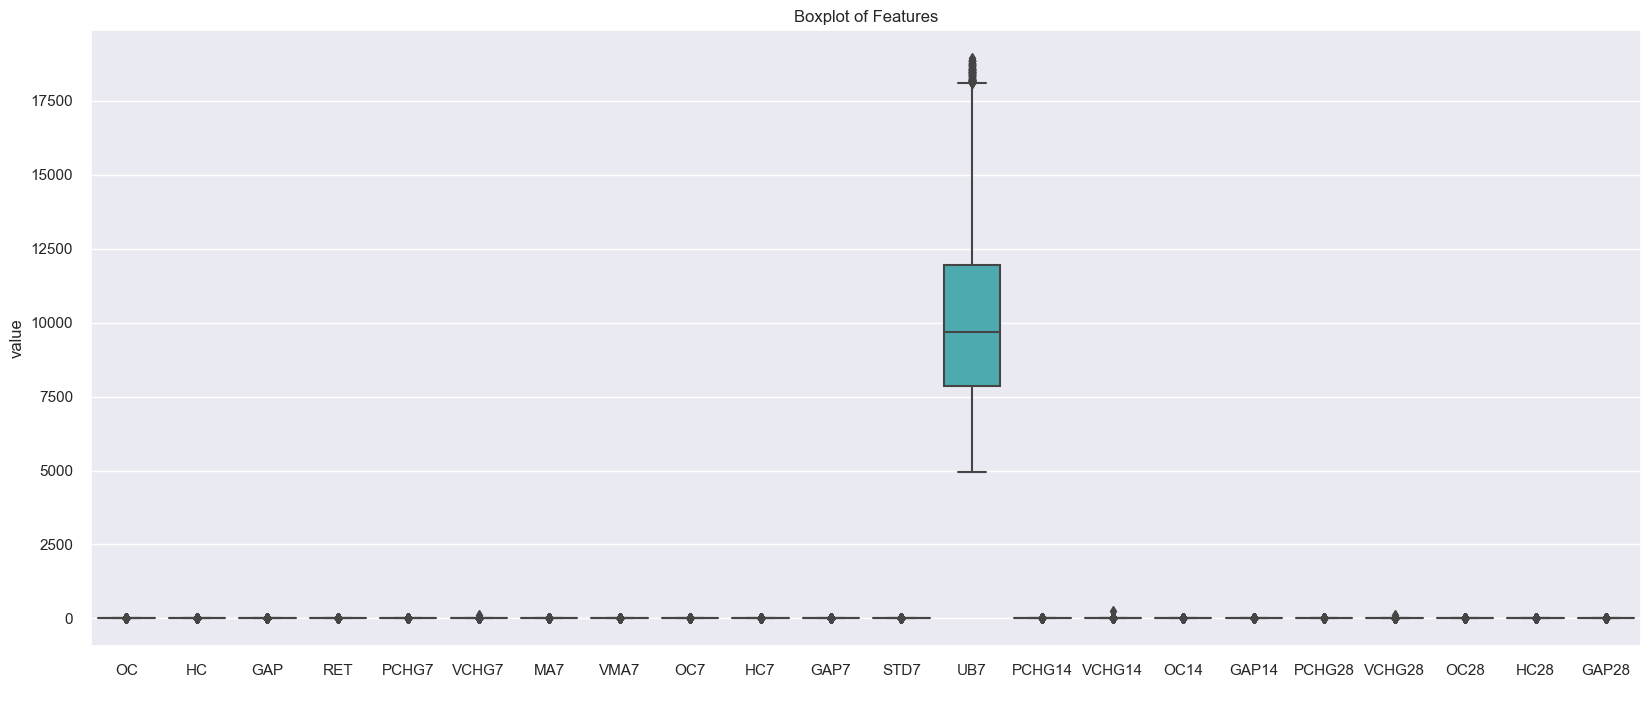

In [13]:
# study the distribution
# fig, ax = plt.subplots(figsize=(14,8))
sns.boxplot(x='variable', y='value', data=pd.melt(X))
plt.xlabel(' ')
plt.title('Boxplot of Features');

### 3 Regression Class

We’ll now create a Regression class for linear estimators : Linear, Lasso, Ridge and ElasticNet

In [14]:
class Regression:
    def __init__(self, X, y, testsize=0.20):
        self.X = X
        self.y = y
        self.testsize = testsize

        # split training and testing dataset
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y,\
                                                test_size=self.testsize, random_state=0, shuffle=False)
    # fit and predict
    def fit_predict(self, estimator, transformer, alpha=None, l1_ratio=None):
        try:
        # subsume estimators and transformer into a pipeline
            model = Pipeline([
            ('scaler', transformer),
            ('regressor', estimator)
            ])

            # fit/train model
            model.fit(self.X_train, self.y_train)

            # predict lables
            y_pred = model.predict(self.X_test)
        
        except Exception as e:
            print(str(e))
        return model, model['regressor'].intercept_, model['regressor'].coef_, y_pred
    
    # evaluate metrics
    def eval_metrics(self, model, y_pred):
        # evaluate metrics
        
        mse = mean_squared_error(self.y_test, y_pred, squared=True)
        rmse = mean_squared_error(self.y_test, y_pred, squared=False)
        r2train = model.score(self.X_train, self.y_train)
        r2test = model.score(self.X_test, self.y_test)
        
        return mse, rmse, r2train, r2test
    
    # plot coefficients as a function of lambda

    def plot_coeff(self, modelname):
        
        coef = []
        model = Regression(self.X, self.y, 0.20)
        alpha_range = np.logspace(2, -2, 200)
        if modelname == 'Lasso':
            for i in alpha_range:
                coef.append(model.fit_predict(Lasso(alpha=i, random_state=0), MinMaxScaler())[2])
            
        elif modelname == 'Ridge':
            alpha_range = np.logspace(6, -2, 200)
            for i in alpha_range:
                coef.append(model.fit_predict(Ridge(alpha=i, random_state=0), MinMaxScaler())[2])
        elif modelname == 'ElasticNet':
            for i in alpha_range:
                coef.append(model.fit_predict(ElasticNet(alpha=i, random_state=0), MinMaxScaler())[2])
            
        # Plot Coefficients
        fig = plt.figure(figsize=(20,8))
        ax = plt.axes()
        ax.plot(alpha_range, coef)
        ax.set_xscale('log')
        ax.legend(feature_names, loc=0)
        # ax.set_xlim(ax.get_xlim()[::-1]) # reverse axis
        ax.set_title(f'{modelname} coefficients as a function of the regularization')
        ax.set_xlabel('$\lambda$')
        ax.set_ylabel('$\mathbf{w}$')
        return plt.show()

#### 3.1 Linear Regression
In linear regression, the model coefficients are selected by minimizing a loss function. First, we
instantiate the class object and pass the estimator and transformer to fit and predict the model.

In [15]:
# instantiate
lr = Regression(X, y)
# fit Linear Regression
lr_model , lr_intercept, lr_coef, lr_y_pred = lr.fit_predict(LinearRegression(), MinMaxScaler())
print(f"\n Model: {lr_model} \n Intercept: {lr_intercept} \n Coefficients: \n {lr_coef}")



 Model: Pipeline(steps=[('scaler', MinMaxScaler()), ('regressor', LinearRegression())]) 
 Intercept: 2908.506115524752 
 Coefficients: 
 [-15152.54289514     59.84289711 -12842.72788099  21034.50509902
 -19638.64573201   -142.85365193   1597.25036071    -52.90704977
  10784.88855444   -962.93763779  16332.59580405   -805.73544021
   7407.17868876   3038.94103025     35.51362605  -1389.86239819
  -2663.16545765   3632.37495083    -59.69122303  -1932.98166345
    271.73920383  -3142.66928796]


### 4 Regularized Regression
If the coeficients are too large in linear regression, it can lead to overfitting the model. We do
regularization to over come such issues that penalises large coefficients. Lasso and Ridge regression
are penalty regression that prevent over-fitting from the simple linear regression.

#### 4.1 LASSO
The Least Absolute Shrinkage and Selection Operator (LASSO) is a variation of linear regression. In
Lasso, the loss function is minimized by limiting the sum of absolute values of the model coefficients
where the L1 penalty term is added to the Mean Square Error (MSE). The L1 penalty term not
only shrinks the coefficents, but shrinks some of them to zero and that is very useful for feature
selection.


$$
L=\frac{1}{n} \sum_{i=1}^n\left(y_i-w_0-\sum_{j=1}^p x_{i j} w_j\right)^2+\lambda \sum_{j=1}^p\left|w_j\right|
$$
where, $\lambda$ is the regularization penalty.




 Model: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor', Lasso(alpha=0.3, random_state=0))]) 
 Intercept: 3732.9973444928537 
 Coefficients: 
 [ 0.00000000e+00 -2.55913938e+02  0.00000000e+00  1.10784982e+00
 -0.00000000e+00 -0.00000000e+00  1.60540227e+03 -3.28647147e+01
 -7.18927619e+01 -7.52779897e+02  2.95170917e+02 -4.53689390e+02
  7.39904013e+03  0.00000000e+00 -0.00000000e+00  2.97289445e+01
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  5.91509957e+01 -0.00000000e+00]


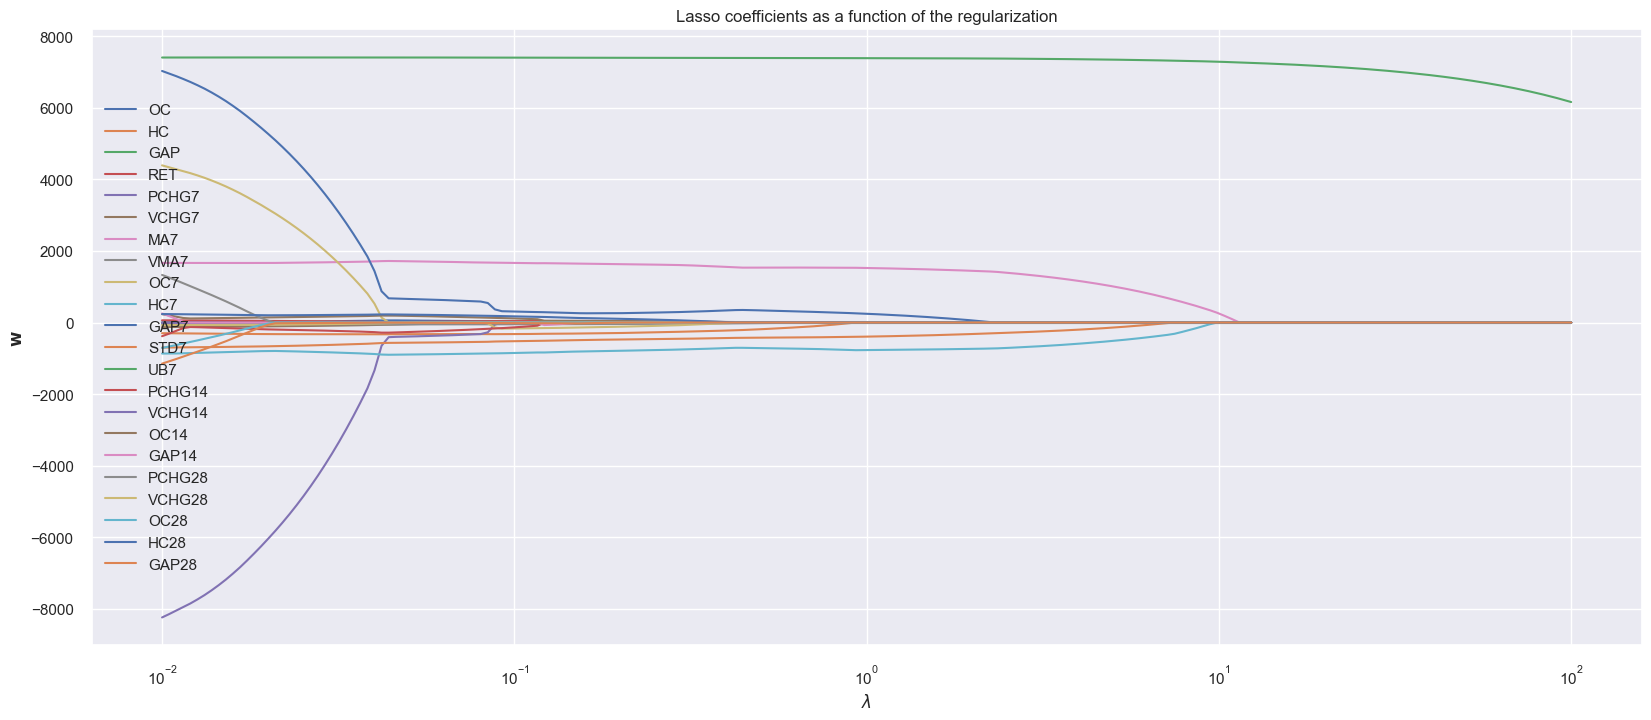

In [16]:
# instantiate
lasso = Regression(X,y)
# fit Lasso
lasso_model , lasso_intercept, lasso_coef, lasso_y_pred = lasso.fit_predict(Lasso(alpha=0.3, random_state=0), MinMaxScaler())
print(f"\n Model: {lasso_model} \n Intercept: {lasso_intercept} \n Coefficients: \n {lasso_coef}")
      
      
# plot coefficients
lasso.plot_coeff('Lasso')


#### 4.2 Ridge
In ridge regression, the cost function is altered by adding a L2 penality equivalent to square of the magnitude of the coefficients. The Ridge regression shrinks the coefficients and helps to reduce the multi-collinearity. As seen from the above graph, when $\lambda \rightarrow 0$, the cost function becomes similar to the linear regression cost function.
$$
L=\frac{1}{n} \sum_{i=1}^n\left(y_i-w_0-\sum_{j=1}^p x_{i j} w_j\right)^2+\lambda \sum_{j=1}^p w_j^2
$$

In [17]:
# instantiate
ridge = Regression(X,y)
# fit Ridge
ridge_model , ridge_intercept, ridge_coef, ridge_y_pred = ridge.fit_predict(Ridge(alpha=1, random_state=0), MinMaxScaler())
print(f"\n Model: {ridge_model} \n Intercept: {ridge_intercept} \n Coefficients: \n {ridge_coef}")



 Model: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor', Ridge(alpha=1, random_state=0))]) 
 Intercept: 3619.2549859099745 
 Coefficients: 
 [ 1.28772303e+02 -4.27306449e+02  7.88508714e+01  1.61908109e+02
  8.38082694e+01 -6.98335661e+01  1.22981148e+03 -4.44082200e+01
 -6.88128333e+01 -6.68893291e+02  4.65282201e+02 -4.90945476e+02
  7.35982645e+03 -8.62009614e+01  1.44824650e+01  1.20876762e+02
  3.02986138e+01  1.89294187e+01 -5.87469715e+01 -1.87182123e+01
  8.31896901e+01 -2.15278456e+00]


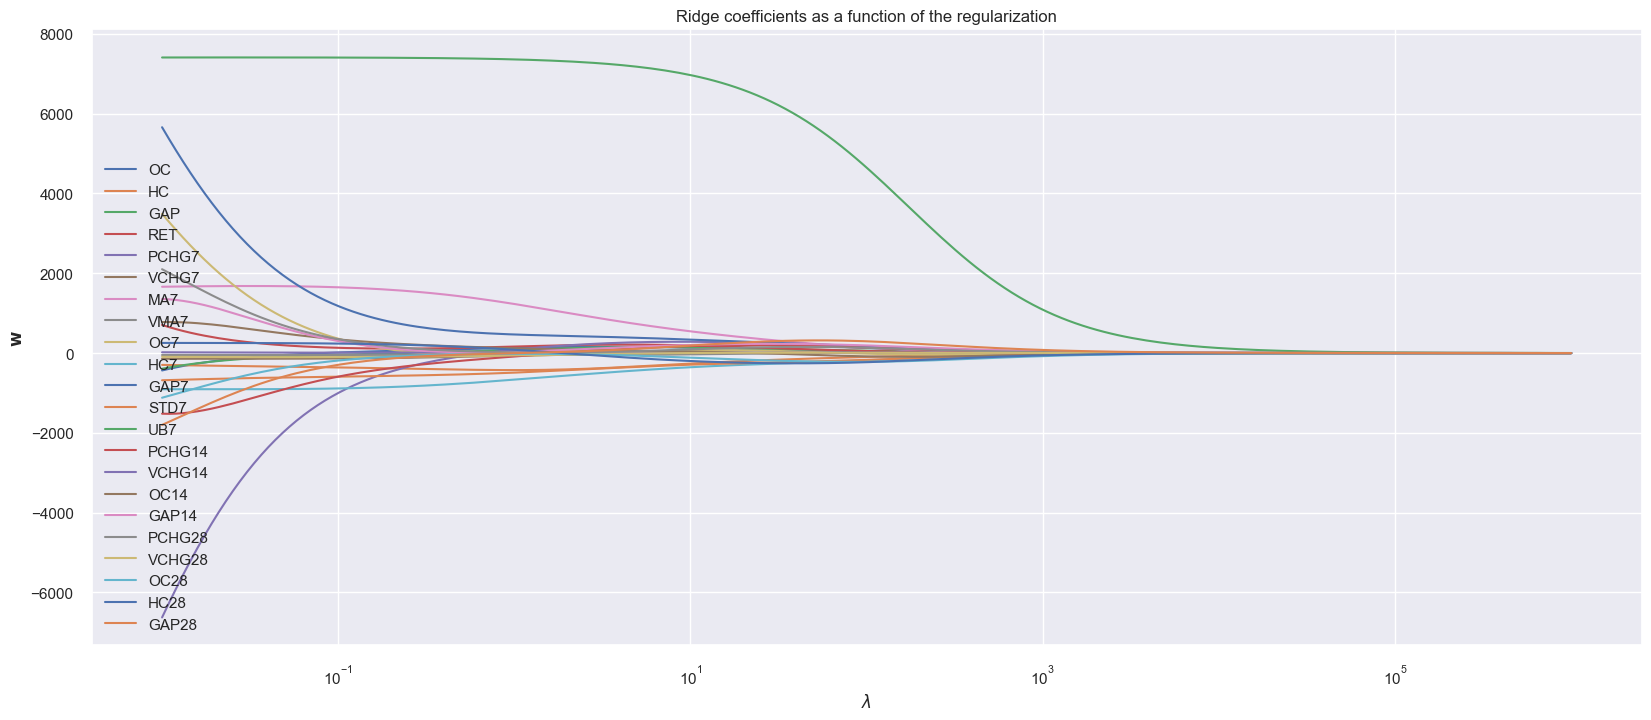

In [18]:
# plot coefficients
ridge.plot_coeff('Ridge')


#### 4.3 ElasticNet Regression

ElasticNet combines the properties of both Lasso and Ridge regression. It penalizes the model using both the L1 and L2 norm.
$$
L=\frac{1}{n} \sum_{i=1}^n\left(y_i-w_0-\sum_{j=1}^p x_{i j} w_j\right)^2+\lambda\left(\frac{1-\alpha}{2} \sum_{j=1}^p w_j^2+\alpha \sum_{j=1}^p\left|w_j\right|\right)
$$
where $0 \leq \alpha \leq 1$. Elastic net is same as lasso when $\alpha=1$ and ridge when $\alpha=0$. For other values of $\alpha$. the penalty term interpolate between L1 and L2 norm of the coefficient.

In [28]:
# instantiate
elasticnet = Regression(X,y)
# fit ElasticNet
elasticnet_model , elasticnet_intercept, elasticnet_coef, elasticnet_y_pred = elasticnet.fit_predict(ElasticNet(alpha=0.01, l1_ratio=0.4, tol=0.5, random_state=0), MinMaxScaler())
print(f"\n Model: {elasticnet_model} \n Intercept: {elasticnet_intercept} \n Coefficients: \n {elasticnet_coef}")



 Model: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor',
                 ElasticNet(alpha=0.01, l1_ratio=0.4, random_state=0,
                            tol=0.5))]) 
 Intercept: 3720.0302206850483 
 Coefficients: 
 [ 4.18335655e+02 -1.10872112e+02  9.03954505e+01  2.85566355e+02
  6.10931977e+02 -4.56496902e+00  5.00954205e+02 -4.81339822e+01
 -3.51777821e+02 -5.52498966e+02  4.27015392e+02 -6.45342429e+02
  6.91227880e+03  1.46313313e+02  1.40612089e+01  1.10714409e+02
  1.56313930e+02  8.94256553e+01  7.10912775e+00 -1.00332782e+02
 -4.49532267e+01  5.78198082e+01]


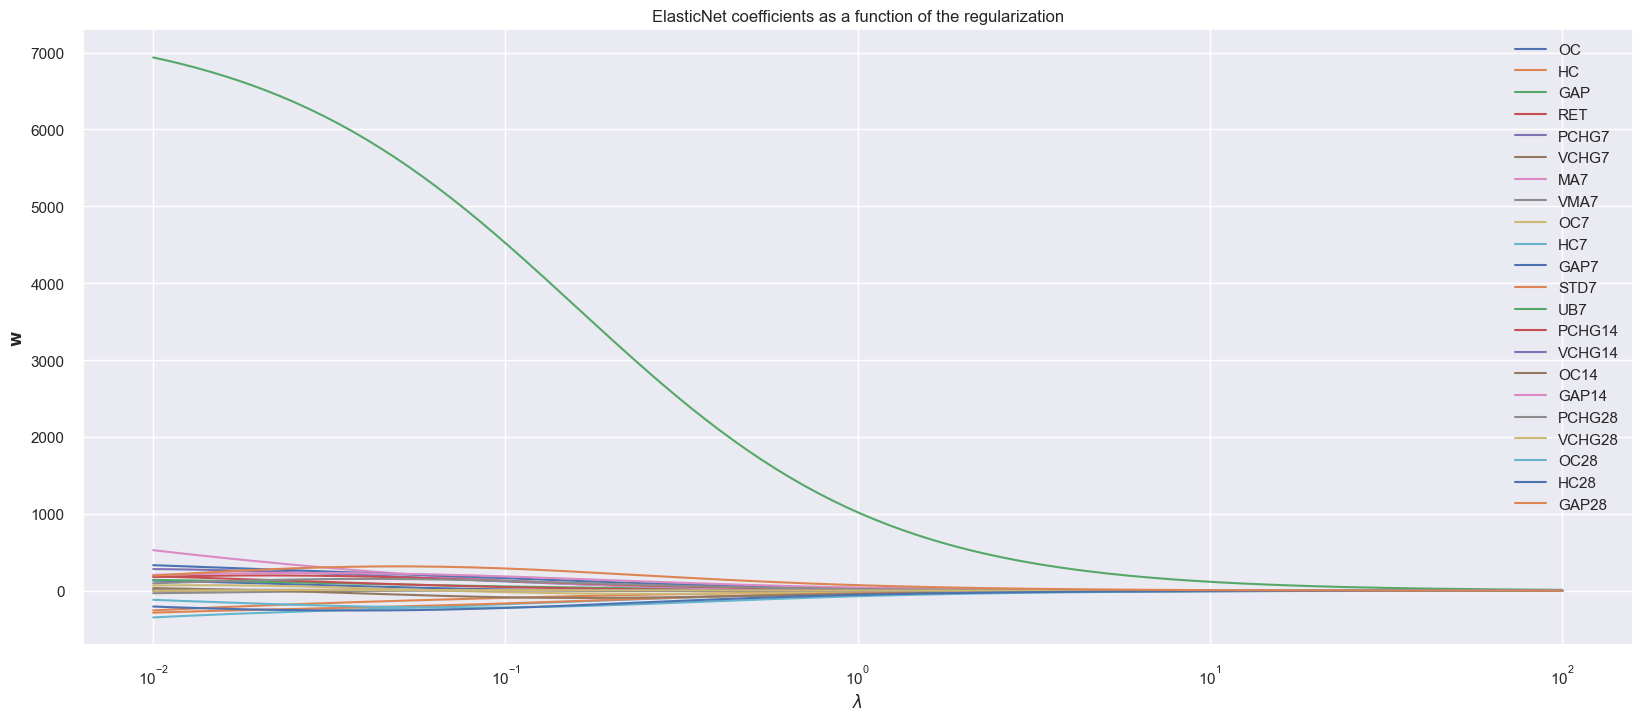

In [29]:
# plot coefficients
elasticnet.plot_coeff('ElasticNet')


### 5 Model Comparision


In [30]:
# compare model coefficients
coef_df = pd.DataFrame({
'LR': lr_coef,
'Lasso': lasso_coef,
'Ridge': ridge_coef,
'ElasticNet': elasticnet_coef
}, index = feature_names)
coef_df

,LR,Lasso,Ridge,ElasticNet
OC,"-15,152.5429",0.0000,128.7723,418.3357
HC,59.8429,-255.9139,-427.3064,-110.8721
GAP,"-12,842.7279",0.0000,78.8509,90.3955
RET,"21,034.5051",1.1078,161.9081,285.5664
PCHG7,"-19,638.6457",-0.0000,83.8083,610.9320
VCHG7,-142.8537,-0.0000,-69.8336,-4.5650
MA7,"1,597.2504","1,605.4023","1,229.8115",500.9542
VMA7,-52.9070,-32.8647,-44.4082,-48.1340
OC7,"10,784.8886",-71.8928,-68.8128,-351.7778
HC7,-962.9376,-752.7799,-668.8933,-552.4990


In [31]:
 # compare evaluation metrics
eval_df = pd.DataFrame({
'LR': lr.eval_metrics(lr_model, lr_y_pred),
'Lasso': lasso.eval_metrics(lasso_model, lasso_y_pred),
'Ridge': ridge.eval_metrics(ridge_model, ridge_y_pred),
'ElasticNet': elasticnet.eval_metrics(elasticnet_model, elasticnet_y_pred)
}, index = ['MSE', 'RMSE', 'R2_train', 'R2_test'])
eval_df


,LR,Lasso,Ridge,ElasticNet
MSE,"52,464.1724","55,841.4103","60,390.4692","359,785.2005"
RMSE,229.0506,236.3079,245.7447,599.8210
R2_train,0.9969,0.9964,0.9963,0.9918
R2_test,0.9777,0.9762,0.9743,0.8468


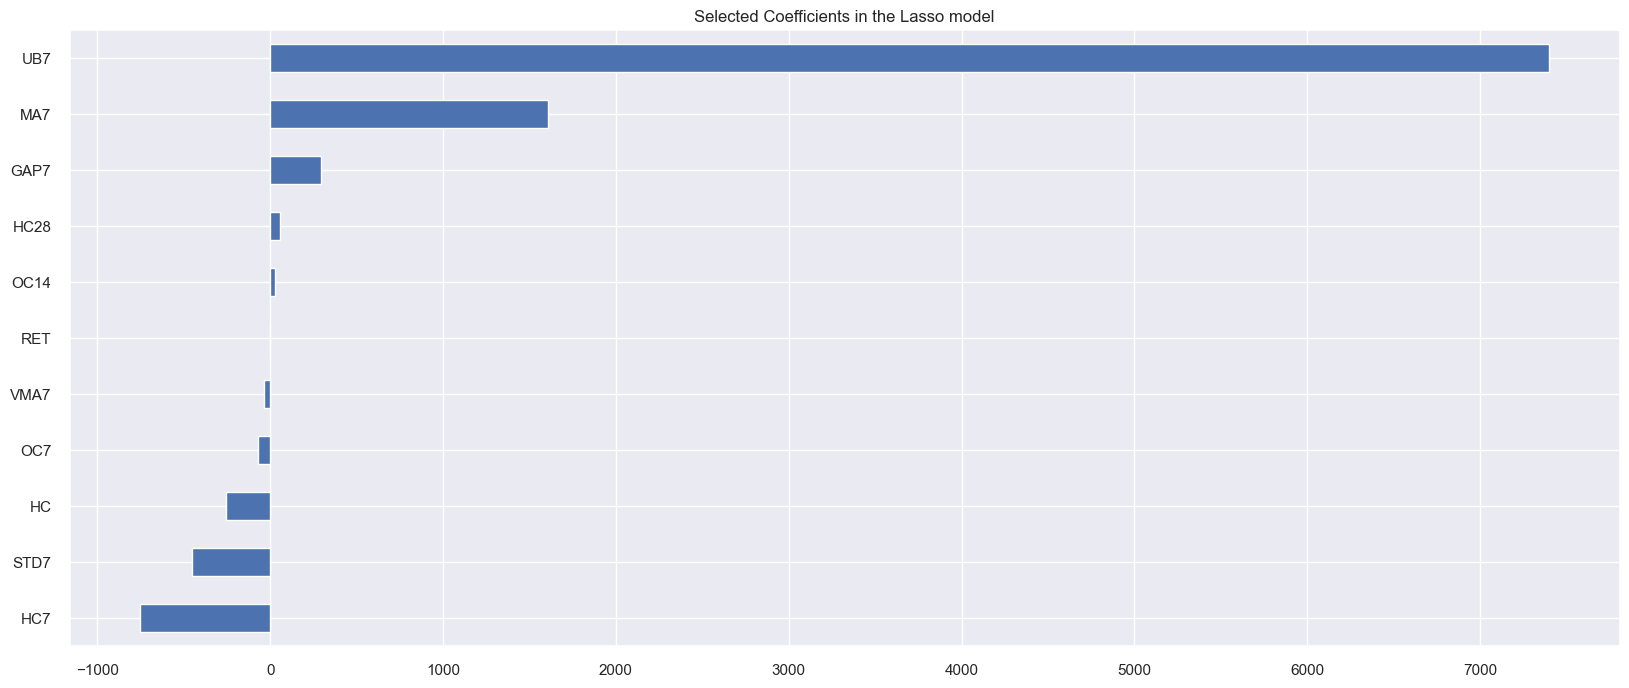

In [32]:
# selected coefficients
coef_df['Lasso'][coef_df['Lasso']!=0].sort_values().plot(kind = 'barh')
plt.title('Selected Coefficients in the Lasso model')
plt.show()